In [1]:
# Read and split the file content
with open('TinyStories-valid.txt', 'r') as file:
    content = file.read()

tiny_stories = content.split("<|endoftext|>")

In [2]:
import numpy as np
from tqdm.auto import tqdm
import re

# Combine summary + dialogue and split on whitespace
raw_lens = [len(s.split()) for s in tqdm(tiny_stories, total=len(tiny_stories))]

lens = np.array(raw_lens)

# Print summary stats
def pct(x): return np.percentile(lens, x)

print(f"Total examples    : {len(lens):,}")
print(f"Min / Max words   : {lens.min()} / {lens.max()}")
print(f"Mean ± std        : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- Percentiles (word count per raw text pair) ---")
for p in [50, 90, 95, 98, 99]:
    print(f"{p:>3}% : {pct(p):.0f} words")

/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 21990/21990 [00:00<00:00, 206296.62it/s]

Total examples    : 21,990
Min / Max words   : 13 / 841
Mean ± std        : 170.7 ± 75.3
--- Percentiles (word count per raw text pair) ---
 50% : 151 words
 90% : 252 words
 95% : 332 words
 98% : 417 words
 99% : 476 words


In [3]:
MAX_LEN = int(pct(90))

def clean_text(text: str) -> str:
    """
    Remove HTML, normalize whitespace, preserve punctuation/numbers/casing.
    """
    text = text.replace('\r', ' ').replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

stories = []

for i in tiny_stories:
    try:
        if len(i.strip().split()) < MAX_LEN: 
            stories.append(clean_text(i))
    except:
        pass

1000



2000



3000



4000



6000



8000





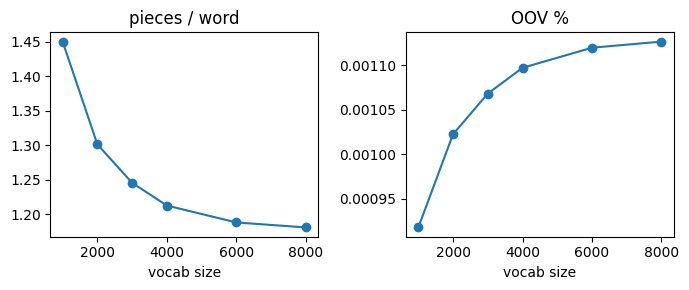

In [4]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import matplotlib.pyplot as plt
        
split = int(0.95*len(stories))
train_texts, valid_texts = stories[:split],stories[split:]

def train_tokenizer(text_iter, vocab_size: int) -> Tokenizer:
    tok = Tokenizer(models.BPE(unk_token="[UNK]"))
    tok.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size,
                                  min_frequency=2,
                                  special_tokens=["[UNK]"])
    tok.train_from_iterator(text_iter, trainer)
    return tok

def avg_pieces_per_word(tok: Tokenizer, texts) -> float:
    pieces = words = 0
    for t in texts:
        ids   = tok.encode(t).ids
        pieces += len(ids)
        words  += len(t.split())
    return pieces / words

vocab_sizes = [1000,2000,3000,4000,6000,8000]
pieces_per_word, oov_rate = [], []

for k in vocab_sizes:
    print(k)
    tok = train_tokenizer(train_texts, k)

    # 1) average sub-words per word on validation set
    pieces_per_word.append(avg_pieces_per_word(tok, valid_texts))

    # 2) OOV percentage on validation set
    unk_id = tok.token_to_id("[UNK]")
    total = unk = 0
    for t in valid_texts:
        ids   = tok.encode(t).ids
        total += len(ids)
        unk   += sum(id_ == unk_id for id_ in ids)
    oov_rate.append(100 * unk / total)

# ── plot ───────────────────────────────────────────────────────────────
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(vocab_sizes, pieces_per_word, marker='o')
plt.title("pieces / word"); plt.xlabel("vocab size")

plt.subplot(1,2,2)
plt.plot(vocab_sizes, oov_rate, marker='o')
plt.title("OOV %"); plt.xlabel("vocab size")

plt.tight_layout(); plt.show()

In [5]:
VOCAB_SIZE = 4000
SPECIAL_TOKENS = ['[PAD]', '[UNK]', '[BOS]', '[EOS]', '[SEP]','[IMG_TOKEN]']

In [6]:
import re
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing

# Initialize and train
tokenizer = Tokenizer(BPE(unk_token='[UNK]'))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=SPECIAL_TOKENS)
tokenizer.train_from_iterator(train_texts, trainer=trainer)

# 3) Configure post-processing, padding & truncation ------------------
pad_id = tokenizer.token_to_id('[PAD]')
unk_id = tokenizer.token_to_id('[UNK]')
bos_id = tokenizer.token_to_id('[BOS]')
eos_id = tokenizer.token_to_id('[EOS]')
sep_id = tokenizer.token_to_id('[SEP]')
img_token_id = tokenizer.token_to_id('[IMG_TOKEN]')

# Add BOS/EOS around single sequences
tokenizer.post_processor = TemplateProcessing(
    single='$A',
    special_tokens=[],
)

Total samples    : 18,793
Min / Max tokens : 15 / 350
Mean ± std       : 182.4 ± 42.0
--- percentiles (tokens) ---
 50% : 178
 90% : 238
 95% : 262
 98% : 290
 99% : 302


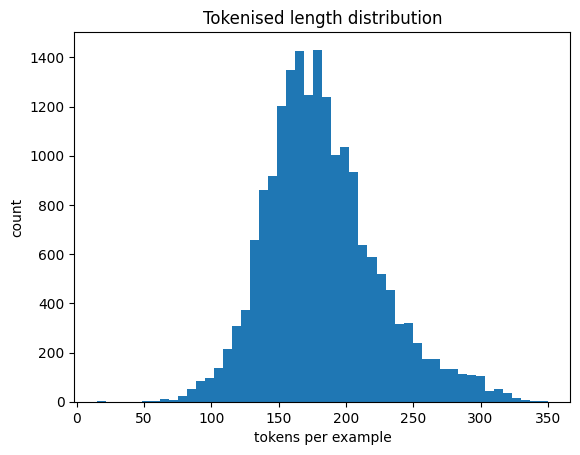

In [7]:
# ------------------------------------------------------------
# 0)  Make sure `tok` points to the FINAL tokenizer
#     → trained on the full corpus with your chosen vocab_size
# ------------------------------------------------------------
tok = tokenizer          # whatever variable you use

# ------------------------------------------------------------
# 1)  Get token counts for every example
#     (here: concatenate summary + dialogue; split if you want)
# ------------------------------------------------------------
lens = []

for txt in train_texts:
    ids   = tok.encode(txt).ids
    lens.append(len(ids))

lens = np.array(lens)

# ------------------------------------------------------------
# 2)  Print key stats
# ------------------------------------------------------------
def pct(x): return np.percentile(lens, x)

print(f"Total samples    : {len(lens):,}")
print(f"Min / Max tokens : {lens.min()} / {lens.max()}")
print(f"Mean ± std       : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- percentiles (tokens) ---")
for p in (50, 90, 95, 98, 99):
    print(f"{p:>3}% : {pct(p):.0f}")

# ------------------------------------------------------------
# 3)  Quick histogram    (no seaborn, single plot, no colors set)
# ------------------------------------------------------------
plt.hist(lens, bins=50)
plt.xlabel("tokens per example")
plt.ylabel("count")
plt.title("Tokenised length distribution")
plt.show()

In [8]:
BATCH_SIZE = 32
MAX_LEN = int(pct(p))

In [9]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary

def encode_example(text: str):
    # 1. Tokenize without padding/truncation
    enc = tokenizer.encode(text)
    ids = enc.ids

    # 2. Add BOS token
    ids = [bos_id] + ids

    # 3. Truncate
    if len(ids) > MAX_LEN:
        ids = ids[:MAX_LEN]

    # 4. Prepare labels
    labels = ids[1:] + [eos_id]

    # 5. Pad to MAX_LEN
    ids = ids + [pad_id] * (MAX_LEN - len(ids))
    labels = labels + [pad_id] * (MAX_LEN - len(labels))

    # 6. Loss mask
    loss_mask = [float(token != pad_id) for token in labels]

    return torch.tensor(ids, dtype=torch.long), \
           torch.tensor(labels, dtype=torch.long), \
           torch.tensor(loss_mask, dtype=torch.float32)




class TextDataset(Dataset):
    def __init__(self, texts):
        self.examples = [encode_example(t) for t in texts]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        input_ids, labels, loss_mask = self.examples[idx]
        return {
            "input_ids": input_ids,
            "labels": labels,
            "loss_mask": loss_mask
        }

dataset = TextDataset(train_texts)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [10]:
vocab = tokenizer.get_vocab()           # indices 0 … V

id_to_token = {idx: tok for tok, idx in vocab.items()}

# 2) Decoder: drop PADs, replace unknown IDs with '?'
def decode_token_ids(token_ids: list[int]) -> str:
    tokens = []
    for tid in token_ids:
        if tid == pad_id:
            continue
        tokens.append(id_to_token.get(tid, '?'))
    return ' '.join(tokens)

# Take one batch
batch = next(iter(loader))

input_ids = batch['input_ids']   # shape: [B, MAX_LEN]
labels    = batch['labels']      # shape: [B, MAX_LEN]

for i in range(input_ids.size(0)):
    ids_row = input_ids[i].tolist()
    lbl_row = labels[i].tolist()

    print(f"\n🟢 Sample {i+1}")
    print("  Input IDs: ", ids_row)
    print("  Decoded:   ", decode_token_ids(ids_row))  # Assumes you have this function defined
    print("  Label IDs: ", lbl_row)




🟢 Sample 1
  Input IDs:  [2, 171, 160, 83, 34, 163, 201, 618, 149, 18, 610, 263, 149, 161, 100, 275, 76, 459, 424, 89, 83, 131, 2572, 18, 89, 83, 1015, 744, 860, 353, 77, 475, 384, 128, 89, 83, 1767, 18, 122, 124, 16, 89, 210, 75, 172, 75, 72, 320, 18, 89, 263, 100, 574, 146, 100, 574, 127, 269, 18, 149, 249, 232, 317, 403, 112, 89, 281, 75, 2160, 100, 763, 18, 89, 1583, 77, 1583, 479, 100, 574, 127, 399, 6, 475, 83, 1117, 115, 415, 2572, 149, 83, 18, 89, 83, 1015, 744, 860, 353, 146, 89, 83, 131, 599, 18, 475, 2377, 100, 275, 76, 459, 77, 384, 128, 89, 83, 131, 390, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [11]:
j=1
print(batch["loss_mask"][j].numpy())
print('\n',decode_token_ids(batch["labels"][j].numpy()))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 once upon a time , there was a little pig . she was very alert and one day , s

In [12]:
from model import *

class BuildTransformer(nn.Module):
    def __init__(self, *, num_layers, d_model, num_heads, input_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.token_embedding = TokenEmbedding(vocab_size=input_vocab_size, d_model=d_model)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                               input_vocab_size=input_vocab_size, dropout_rate=dropout_rate)

    def forward(self, inputs):
        x = inputs
        # Create padding mask (True for padding tokens, False otherwise)
        pad_mask = (x == 0)  # Assuming padding token is 0, as in TokenEmbedding's padding_idx
        x = self.token_embedding(x)
        x = self.decoder(x, pad_mask=pad_mask)
        return x

# Example instantiation
num_layers = 2
d_model = 256
num_heads = 8  # 32 dim per head
dropout_rate = 0.1
VOCAB_SIZE = 4000  # Example value, replace with actual VOCAB_SIZE
MAX_LEN = 180      # Example value, replace with actual MAX_LEN

model = BuildTransformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    input_vocab_size=VOCAB_SIZE,
    dropout_rate=dropout_rate
)

# Build weights by running a forward pass
dummy = torch.zeros((1, MAX_LEN), dtype=torch.int64)
_ = model(dummy)

model.load_state_dict(torch.load('build_transformer_trained_weights.pth', map_location='cpu'))

for name, param in model.named_parameters():
    if not 'lora' in name.lower():
        param.requires_grad = False

# Model summary
summary(model, input_size=(1, MAX_LEN), dtypes=[torch.int64])

/var/folders/17/w3818qh1047crr4wkhgmjkvh0000gn/T/ipykernel_66968/1011780592.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('build_tran

Layer (type:depth-idx)                             Output Shape              Param #
BuildTransformer                                   [1, 180, 4000]            --
├─TokenEmbedding: 1-1                              [1, 180, 256]             --
│    └─Embedding: 2-1                              [1, 180, 256]             (1,024,000)
├─Decoder: 1-2                                     [1, 180, 4000]            --
│    └─Dropout: 2-2                                [1, 180, 256]             --
│    └─ModuleList: 2-3                             --                        --
│    │    └─DecoderLayer: 3-1                      [1, 180, 256]             674,304
│    │    └─DecoderLayer: 3-2                      [1, 180, 256]             674,304
│    └─RMSNorm: 2-4                                [1, 180, 256]             (256)
│    └─Linear: 2-5                                 [1, 180, 4000]            (1,028,000)
Total params: 3,400,864
Trainable params: 36,864
Non-trainable params: 3,364,000
Tot

In [14]:
print("Trainable Parameters:")
print("-" * 60)
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        param_count = param.numel()
        print(f"Parameter: {name:<50} Shape: {str(param.shape):<20} Parameters: {param_count}")
        total_params += param_count
print("-" * 60)
print(f"Total Trainable Parameters: {total_params:,}")

Trainable Parameters:
------------------------------------------------------------
Parameter: decoder.dec_layers.0.causal_self_attention.mha.lora_wq.A.weight Shape: torch.Size([8, 256]) Parameters: 2048
Parameter: decoder.dec_layers.0.causal_self_attention.mha.lora_wq.B.weight Shape: torch.Size([256, 8]) Parameters: 2048
Parameter: decoder.dec_layers.0.causal_self_attention.mha.lora_wv.A.weight Shape: torch.Size([8, 256]) Parameters: 2048
Parameter: decoder.dec_layers.0.causal_self_attention.mha.lora_wv.B.weight Shape: torch.Size([256, 8]) Parameters: 2048
Parameter: decoder.dec_layers.0.ffn.swiglu.lora_lin1.A.weight Shape: torch.Size([8, 256]) Parameters: 2048
Parameter: decoder.dec_layers.0.ffn.swiglu.lora_lin1.B.weight Shape: torch.Size([1024, 8]) Parameters: 8192
Parameter: decoder.dec_layers.1.causal_self_attention.mha.lora_wq.A.weight Shape: torch.Size([8, 256]) Parameters: 2048
Parameter: decoder.dec_layers.1.causal_self_attention.mha.lora_wq.B.weight Shape: torch.Size([256, 8])

In [15]:
print("Non Trainable Parameters:")
print("-" * 60)
total_params = 0
for name, param in model.named_parameters():
    if not param.requires_grad:
        param_count = param.numel()
        print(f"Parameter: {name:<50} Shape: {str(param.shape):<20} Parameters: {param_count}")
        total_params += param_count
print("-" * 60)
print(f"Total Non Trainable Parameters: {total_params:,}")

Non Trainable Parameters:
------------------------------------------------------------
Parameter: token_embedding.embedding.weight                   Shape: torch.Size([4000, 256]) Parameters: 1024000
Parameter: decoder.dec_layers.0.causal_self_attention.mha.wq.weight Shape: torch.Size([256, 256]) Parameters: 65536
Parameter: decoder.dec_layers.0.causal_self_attention.mha.wk.weight Shape: torch.Size([256, 256]) Parameters: 65536
Parameter: decoder.dec_layers.0.causal_self_attention.mha.wv.weight Shape: torch.Size([256, 256]) Parameters: 65536
Parameter: decoder.dec_layers.0.causal_self_attention.mha.wo.weight Shape: torch.Size([256, 256]) Parameters: 65536
Parameter: decoder.dec_layers.0.causal_self_attention.rmsnorm.scale Shape: torch.Size([256])    Parameters: 256
Parameter: decoder.dec_layers.0.ffn.swiglu.lin1.weight        Shape: torch.Size([1024, 256]) Parameters: 262144
Parameter: decoder.dec_layers.0.ffn.swiglu.lin2.weight        Shape: torch.Size([256, 512]) Parameters: 131072
P

In [16]:
class TextDataset(Dataset):
    def __getitem__(self, idx):
        return {
            "input_ids": input_ids,     # shape [MAX_LEN]
            "labels": labels,           # shape [MAX_LEN]
            "loss_mask": loss_mask      # shape [MAX_LEN], float mask
        }
    

import torch.nn.functional as F

def masked_sparse_crossentropy(logits, target, mask):
    """
    logits: (B, T, V)
    target: (B, T)
    mask:   (B, T) — float32 (1.0 = include, 0.0 = ignore)
    """
    loss = F.cross_entropy(
        logits.transpose(1, 2),  # shape: (B, V, T)
        target,
        reduction='none'         # we’ll apply masking manually
    )  # shape: (B, T)

    loss = loss * mask  # apply mask
    return loss.sum() / mask.sum()  # normalize over actual tokens

def masked_accuracy(logits, labels, mask):
    preds = logits.argmax(dim=-1)  # shape: (B, T)
    correct = (preds == labels).float() * mask
    return correct.sum() / mask.sum()


In [17]:
from tqdm import tqdm

device = 'cpu'
EPOCHS = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    total_acc = 0
    total_tokens = 0

    # Wrap loader with tqdm for batch-wise progress
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)    # (B, T)
        labels    = batch['labels'].to(device)       # (B, T)
        mask      = batch['loss_mask'].to(device)    # (B, T)

        optimizer.zero_grad()
        logits = model(input_ids)  # expected output shape: (B, T, V)

        loss = masked_sparse_crossentropy(logits, labels, mask)
        acc  = masked_accuracy(logits, labels, mask)

        loss.backward()
        optimizer.step()

        num_tokens = mask.sum().item()
        total_loss += loss.item() * num_tokens
        total_acc  += acc.item()  * num_tokens
        total_tokens += num_tokens

        # Show live batch metrics in tqdm bar
        avg_loss = total_loss / total_tokens
        avg_acc = total_acc / total_tokens
        pbar.set_postfix({"loss": f"{avg_loss:.4f}", "acc": f"{avg_acc:.4f}"})

    print(f"✅ Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f}")

KeyboardInterrupt: 

In [ ]:
def encode_input(text: str, max_len: int = MAX_LEN) -> torch.Tensor:
    """
    Returns [BOS] dialogue [EOS] *without* any padding.
    """
    tokenizer.no_padding()
    tokenizer.enable_truncation(max_length=max_len)
    ids = [bos_id] + tokenizer.encode(clean_text(text)).ids
    return torch.tensor(ids, dtype=torch.long)  # 1-D tensor

@torch.no_grad()
def generate_summary(
    text_ids: torch.Tensor,
    model: torch.nn.Module,
    max_new: int = 30,
    temperature: float = 1.0,
    device: str = "cpu"
) -> torch.Tensor:
    """
    Generate tokens auto-regressively: [BOS] text [EOS]
    """
    model.eval()

    prompt = text_ids.unsqueeze(0).to(device)  # (1, T)

    for _ in range(max_new):
        if prompt.shape[1] > MAX_LEN:
            break

        logits = model(prompt)                 # (1, T, V)
        next_logits = logits[:, -1, :] / temperature  # (1, V)

        probs = torch.softmax(next_logits, dim=-1)     # (1, V)
        next_id = torch.multinomial(probs, num_samples=1)  # (1, 1)

        prompt = torch.cat([prompt, next_id], dim=1)   # append

        if next_id.item() == eos_id:
            break

    return prompt.squeeze(0).cpu()

def display_text(text: str, model, device="cpu"):
    # 1. Encode input
    text_ids = encode_input(text)

    # 2. Generate full sequence
    full_ids = generate_summary(text_ids, model, device=device)

    # 3. Convert to list
    full_ids_list = full_ids.tolist()

    # 4. Decode
    text_str = decode_token_ids(full_ids_list)

    # 5. Print
    print("\n Text:", text_str)


In [ ]:
display_text('milk in kitchen', model)


 Text: [BOS] milk in kitchen t helpful to the air sara to the present , game rolling ant and play missing . he , and picked new house " gave ' ben . the embarrassed , delic . the only of loved . tim okay and the forest beautiful and back to over with it . then . mom the stopped and said couldn in ground to see lex . the their . tim , taught heart was size in smiled it of their soup lived . cop b hands was * . she . hugged . it buttons prin higher special . thankful .
